# What defines your relationship with a beer?

In the following notebook, we explore the idea of how liked beers differ locally and globally. We start by extracting the data and preprocessing it in a way that makes it easier to compare locations of beers and breweries.

In [20]:
import pandas as pd
import numpy as np
import gzip #to read gzip files
import matplotlib.pyplot as plt
import datetime
import pickle
from scipy.stats import linregress

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data extraction and viewing

We start by extracting the data for beers, breweries and users from the two rating websites BeerAdvocate and RateBeer as well as the matched data. We view the dataframe first few rows to get a sense of what the data contains.

In [4]:
PATH = '../'

### BeerAdvocate data

In [5]:
BA_beers = pd.read_csv(PATH+'BeerAdvocate/beers.csv', index_col='beer_id')
BA_beers.head(2)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN


In [6]:
matched_beers = pd.read_csv(PATH+'matched_beer_data/beers.csv', header=1)
matched_beers.head(2)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
0,4.8,3.45,3.439867,3.504068,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.698304,1.000000,1.0
1,6.0,3.86,3.888750,3.768333,NaN,20841,St. Patrick's Ale,Patricks Ale St,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,11,11,52.0,Irish Ale,79.0,0.005754,0.527141,1.0


In [7]:
BA_breweries = pd.read_csv(PATH+'BeerAdvocate/breweries.csv', index_col='id')

BA_breweries['merged_location'] = BA_breweries['location'].copy()
BA_breweries.loc[(BA_breweries['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

BA_breweries.head(2)


,location,name,nbr_beers,merged_location
id,,,,
39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,Kyrgyzstan
39913,Kyrgyzstan,Arpa (АРПА),1,Kyrgyzstan


### RateBeer data

In [8]:
RB_breweries = pd.read_csv(PATH+'RateBeer/breweries.csv', index_col= 'id')

# Add a column where all Users from the united states get 'United States' as location
RB_breweries['merged_location'] = RB_breweries['location'].copy()
RB_breweries.loc[(RB_breweries['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

RB_breweries.head(2)

,location,name,nbr_beers,merged_location
id,,,,
3198,Gabon,Sobraga,3,Gabon
13538,Northern Ireland,Ards Brewing Co.,13,Northern Ireland


In [9]:
matched_breweries = pd.read_csv(PATH+'matched_beer_data/breweries.csv', header=1)
matched_breweries.head(2)

,id,location,name,nbr_beers,id.1,location.1,name.1,nbr_beers.1,diff,sim
0,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.431275,0.889062
1,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.526388,0.863596


In [10]:
BA_users = pd.read_csv(PATH+'BeerAdvocate/users.csv', index_col= 'user_id')
BA_users['joined'] = pd.to_datetime(BA_users['joined'],unit = 's')
BA_users.head(2)

# Add a column where all Users from the united states get 'United States' as location
BA_users['location'] = BA_users['location'].fillna('Unknown')
BA_users['merged_location'] = BA_users['location'].copy()
BA_users.loc[(BA_users['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

In [11]:
RB_users = pd.read_csv(PATH+'RateBeer/users.csv', index_col= 'user_id')
RB_users['joined'] = pd.to_datetime(RB_users['joined'] ,unit = 's')
RB_users.head(2)

# Add a column where all Users from the united states get 'United States' as location
RB_users['location'] = RB_users['location'].fillna('Unknown')
RB_users['merged_location'] = RB_users['location'].copy()
RB_users.loc[(RB_users['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

### Matched data

In [12]:
matched_users = pd.read_csv(PATH+'matched_beer_data/users.csv', header=1)
matched_users['joined'] = pd.to_datetime(matched_users['joined'],unit = 's')
matched_users['joined.1'] = pd.to_datetime(matched_users['joined.1'],unit = 's')
matched_users.head(2)

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,2008-09-08 10:00:00,Germany,6,6,erzengel.248045,Erzengel,erzengel,2008-10-18 10:00:00,Germany,8781,83106,Erzengel,erzengel
1,2012-09-23 10:00:00,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,2013-11-29 11:00:00,"United States, Virginia",6240,290599,GenDV138,gendv138


Extracting matched data ratings

In [45]:
matched_ratings = pd.read_csv(PATH+'matched_beer_data/ratings.csv', encoding = "ISO-8859-1", header=1)
matched_ratings.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃÂ¼ÃÂ. Riecht sc...,83106,Erzengel
1,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,...,Myanmar Brewery and Distillery,1322564400,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing


Next we extract we do some preprocessing on the review data below, and save those into csv format in a DataFrameStorage folder in order to access them later as these computations are very computationally expensive:

# Some preprocessing <br>
## Run these cells only once, then save the dataframe. <br>
## Afterwards you can just load the dataframes and don't loose time to run all the computations again

To allow the merge of the brewery location with the brewery name on df_reviews, we first need to align the column names. <br>
To do so we rename the column "name" of breweries to "brewery_name" (the name of the column in df_reviews). <br>

We use the function df.merge to add the element "location" to the corresponding brewery in df_reviews. <br>
By default the new columns name would be the same as in df_breweries ('location'), we rename it by "brewery_location" to prevent confusion. <br>

After the merging we rename the column of the brewery dataframe again, to have the same name that we had initially.

In [ ]:
#Rename the column name to brewery_name to allow merging with the 
BA_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)
RB_breweries.rename(columns = {'name':'brewery_name'}, inplace = True)


#Add the location to the beer dataframe
df_BA_reviews = (df_BA_reviews.merge(BA_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})
df_RB_reviews = (df_RB_reviews.merge(RB_breweries[['location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns = {'location':'brewery_location'})


#Name the columns back: 
BA_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)
RB_breweries.rename(columns = {'brewery_name':'name'}, inplace = True)

As the different states of the US are described as different locations, but sometimes we want to group the beers by nations and not by states. <br>
To make this possible we add a new column. <br>
This column is called "brewery_merged_location" and is exactly the same as the column "brewery_location" except for the fact, that the different states of the US all take the value "United States".

In [ ]:
# Add a column where all breweries from the united states get 'United States' as location
df_RB_reviews['brewery_merged_location'] = df_RB_reviews['brewery_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'


df_BA_reviews['brewery_merged_location'] = df_BA_reviews['brewery_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['brewery_merged_location'].str.startswith('United States')), 'brewery_merged_location'] = 'United States'

The same approach as for the brewery locations is used to add the country of origin of the users. <br>
To group them by nations we add here a column that sums up the states of the US under the value "United States".

In [ ]:
#Add the country of origin of the reviewer to the review
df_RB_reviews = (df_RB_reviews.merge(RB_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})
df_BA_reviews = (df_BA_reviews.merge(BA_users[['location', 'user_name']], on=['user_name'], how='left')).rename(columns={'location':'user_location'})

# Add a column where all users from the united states get 'United States' as location
df_RB_reviews['user_location'] = df_RB_reviews['user_location'].fillna('Unknown')
df_RB_reviews['user_merged_location'] = df_RB_reviews['user_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

#For BA we have to replace the NaN values
df_BA_reviews['user_location'] = df_BA_reviews['user_location'].fillna('Unknown')
df_BA_reviews['user_merged_location'] = df_BA_reviews['user_location'].copy()
df_BA_reviews.loc[(df_BA_reviews['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

In [ ]:
# Add a column where all users from the united states get 'United States' as location
df_RB_reviews['user_location'] = df_RB_reviews['user_location'].fillna('Unknown')

df_RB_reviews['user_merged_location'] = df_RB_reviews['user_location'].copy()
df_RB_reviews.loc[(df_RB_reviews['user_merged_location'].str.startswith('United States')), 'user_merged_location'] = 'United States'

To avoid doing this computations every time we want to start coding, I suggest to save the dataframes in your data folder. <br>
I separated the code into two cells as the computation can take several minutes.

In [ ]:
#Do that only once. Stores the dataframes so that we can access them more easily next time and have to do the data preprocessing only once
df_BA_reviews.to_csv(PATH+'/DataframeStorage/df_BA_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)

In [ ]:
df_RB_reviews.to_csv(PATH+'/DataframeStorage/df_RB_reviews.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)

In [74]:
df_reviews_all = pd.concat([df_BA_reviews, df_RB_reviews], axis=0)

df_reviews_all.to_csv(PATH+'/DataframeStorage/df_reviews_all.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)

### Extracting BeerAdvocate reviews

In [14]:
#open the csv file
#df_BA_reviews = pd.read_csv('../BeerAdvocate/df_BA_reviews.csv')
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",Gabon,Gabon,"United States, Washington",United States
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,Northern Ireland,Northern Ireland,"United States, New York",United States


### Extracting RateBeer reviews:

In [15]:
#open the csv file
#df_RB_reviews = pd.read_csv('../RateBeer/df_RB_reviews_final.csv')
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",Gabon,Gabon,Poland,Poland
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...,Gabon,Gabon,Spain,Spain


In [73]:
df_reviews_all = pd.read_csv(PATH+'/DataframeStorage/df_reviews_all.csv')

FileNotFoundError: [Errno 2] No such file or directory: '..//DataframeStorage/df_reviews_all.csv'

The dates in df_reviews are saved as strings. <br>
A first step (will be important later) is to transform them to datetime. <br>
Probably this step we will have to do everytime we load the csv file.

In [16]:
#Transform the dates of the reviews from string to datetime
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

# Idea 1: effect of sensory values on beer ratings

On matched data:

In [24]:
df_matched_ratings = matched_ratings.iloc[:,:17]
df_matched_ratings.set_axis(df_matched_ratings.loc[0], axis='columns', inplace=True)
df_matched_ratings = df_matched_ratings.drop(0)
df_matched_ratings.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
1,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,4.8,True,Quadrupel (Quad),5.0,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
2,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,3.0,True,American Adjunct Lager,NaN,NaN,visionthing.639993,visionthing


Here we first extract the data from the matched data dataframe. 

In [83]:
def getLinearRegression(df, attr): 
    df['rating']=np.float64(df['rating'])
    df[attr]=np.float64(df[attr])
    reviews = pd.DataFrame(df[[attr,'rating']]).dropna()
    x = reviews[attr]
    xmin = x.min()
    xmax = x.max()
    y = reviews['rating']
    x = x.tolist()
    y = y.tolist()
    regress = linregress(x,y)
    lr = regress
    a1 = lr[0]*xmin + lr[1]
    a2 = lr[0]*xmax + lr[1]
    return lr, a1, a2, xmin, xmax

This is a method to calculate the linear regression for a an attribute of the beer and its ratings. The function returns the linear regression object, and the minimum and maximum x (the attribute) and y (the regression result) values.

In [84]:
def showPlot(df):
    fig, axs = plt.subplots(2, 2)
    lr, a1, a2, xmin, xmax = getLinearRegression(df, 'palate')
    axs[0, 0].scatter(df['palate'], df['rating'], s=.5, alpha=.7, color='purple')
    axs[0, 0].plot([xmin,xmax],[a1,a2], 'k-')
    axs[0, 0].set(xlabel='Palate rating', ylabel='Overall rating')
    axs[0, 0].set_title(f'(R Value: {np.round(lr[2], 3)})')

    lr, a1, a2, xmin, xmax = getLinearRegression(df, 'aroma')
    axs[0, 1].scatter(df['aroma'], df['rating'], s=.5, alpha=.7, color='purple')
    axs[0, 1].plot([xmin,xmax],[a1,a2], 'k-')
    axs[0, 1].set(xlabel='Aroma rating', ylabel='Overall rating')
    axs[0, 1].set_title(f'(R Value: {np.round(lr[2], 3)})')

    lr, a1, a2, xmin, xmax = getLinearRegression(df, 'taste')
    axs[1, 0].scatter(df['taste'], df['rating'], s=.5, alpha=.7, color='purple')
    axs[1, 0].plot([xmin,xmax],[a1,a2], 'k-')
    axs[1, 0].set(xlabel='Taste rating', ylabel='Overall rating')
    axs[1, 0].set_title(f'(R Value: { np.round(lr[2], 3)})')

    lr, a1, a2, xmin, xmax = getLinearRegression(df, 'appearance')
    axs[1, 1].scatter(df['appearance'], df['rating'], s=.5, alpha=.7, color='purple')
    axs[1, 1].plot([xmin,xmax],[a1,a2], 'k-')
    axs[1, 1].set(xlabel='Appearance rating', ylabel='Overall rating')
    axs[1, 1].set_title(f'(R Value: { np.round(lr[2], 3)})')

    fig.tight_layout()
    plt.show()

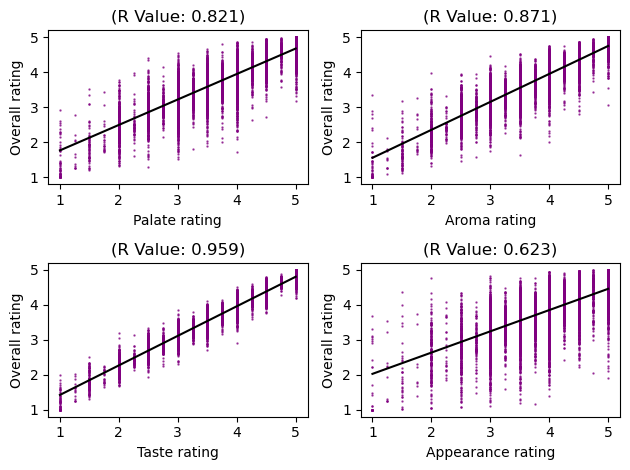

In [85]:
showPlot(df_matched_ratings)

Above we make a subplot containing the linear relationships of all the key sensory beer values with their ratings. We use the r_value from the linear regresion object which indicates the Pearson's correlation coefficient (the strength of the linear relationship) between the two values. We find that taste has the strongest linear relationship with the rating of the beer, followed by the aroma.

## Idea 2: Is a good beer a good beer everywhere? 

### Choosing the 20 best beers in the world

The aim of this idea is to choose the top 20 beers in the world and compare locations of users and the brewery locations for the beers in order to see if there is a bias towards local beers.
In order to choose the best beers, we have decided on a certain number of criteria:
1) Beers that have receieved at least x (to be determined below based on statistical information) number of reviews
2) Reviewers that have reviewed more than x (to be determined below based on statistical information) amount of times (if someone rated a beer once only it's maybe not enough), also we have to keep in mind that a lot of people mindlessly rate beers without reviewing them. Hence here we focus on the number of reviews because it means the person took the time and effort to write a review, making the overall rating more legitimate.
3) Extract the top 20 beers according to the average rating across the two websites.

For those ideas, we use the matched data and the average rating between the two websties for the 3).

### 1) Beers that have recieved a significant number of reviews

First, let's take a look at the distribution of the number of reviews per beer to get a sense of how the x minimal number of reviews a beer should've received in order to select it.

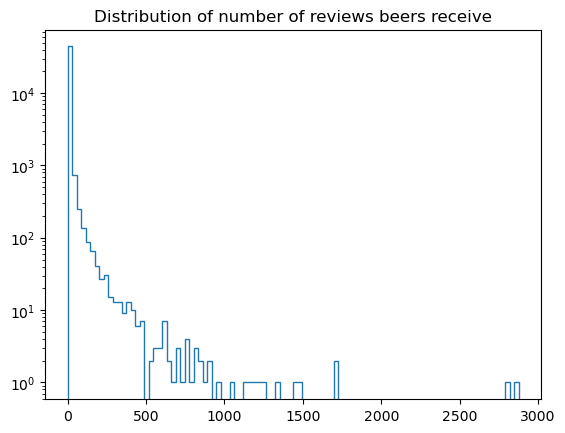

In [34]:
array_100=plt.hist(matched_beers['nbr_reviews'], bins=100,log=True,histtype='step')
plt.title('Distribution of number of reviews beers receive')
plt.show()

In [35]:
matched_beers['nbr_reviews'].describe()

count    45640.000000
mean         5.977826
std         40.955440
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       2875.000000
Name: nbr_reviews, dtype: float64

From the statistical description above, we can see that the quantiles are not very interesting for the choice of our treshold since this is a heavy tailed distribution and 75% of the beers have at most 2 reviews. So we choose to take the beers that have received at least 50 reviews which represents around 2% of the data 

In [36]:
print(f'{"Percentage of beer data with more than 50 reviews :"} { round(len(matched_beers[matched_beers["nbr_reviews"]>50])/len(matched_beers["nbr_reviews"])*100,2) }{"%"}')
print(f'{"Number of beers with more than 50 reviews :"} { len(matched_beers[matched_beers["nbr_reviews"]>50]) }')

Percentage of beer data with more than 50 reviews : 1.95%
Number of beers with more than 50 reviews : 890


In [37]:
# Extracting beers which have received more than 50 reviews
top_beers = matched_beers[matched_beers['nbr_reviews']>50]

In [46]:
#We extract the corresponding ratings/reviews from matched data 
top_beers_ratings = matched_ratings[matched_ratings['beer_id'].isin(top_beers['beer_id']) | matched_ratings['beer_id.1'].isin(top_beers['beer_id.1'])]

### 2) Reviewers that have reviewed more than x amount of times 

Now that we've constructed the dataframe *top_beers_ratings* with the ratings for the beers that are heavily reviewed, we want to look into the reviewers and start by extracting the revieweres who reviewed those beers.

In [47]:
#we extract the users that reviewed the beers that have received more than 50 reviews.
top_beers_reviewers = matched_users[matched_users['user_id'].isin(top_beers_ratings['user_id']) | matched_users['user_id.1'].isin(top_beers_ratings['user_id.1'])]

Let's take a look at the number of ratings per reviewer for the reviewers of the highly reviewed beers: 

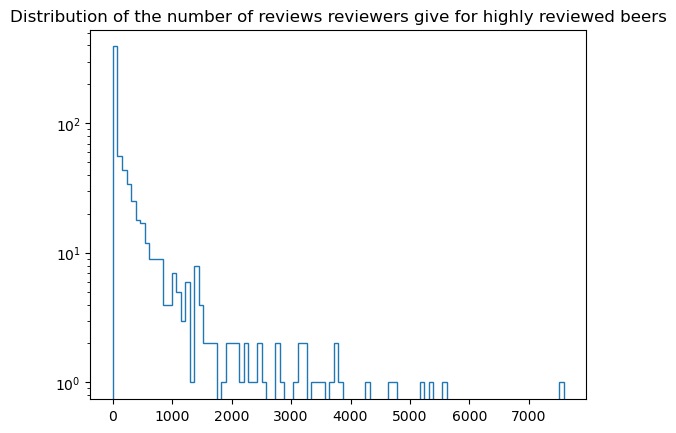

In [48]:
array_100=plt.hist(top_beers_reviewers['nbr_reviews'], bins=100,log=True,histtype='step')
plt.title('Distribution of the number of reviews reviewers give for highly reviewed beers')
plt.show()

In [49]:
top_beers_reviewers[['nbr_reviews']].describe()

,nbr_reviews
count,711.000000
mean,365.544304
std,804.331349
min,0.000000
25%,7.000000
50%,54.000000
75%,327.000000
max,7593.000000


Since the mean is close to the median, this is not a heavy tailed distribution (it may be an exponential distribution). Since here the 3rd percentile already represents a significant number of reviews, we choose to select reviewers who have written more than that amount of reviews (327).

In [52]:
#We decide to filter by the reviewers that have put a number of reviews (not ratings) higher than the third percentile
top_beers_reviewers = top_beers_reviewers.loc[top_beers_reviewers['nbr_reviews']>327]

Now we go back to the beers we've extracted earlier and subset them by the reviewers exctracted above

In [53]:
#filtering the beer ratings by the top beer reviewers
top_beers_ratings = top_beers_ratings[top_beers_ratings['user_id'].isin(top_beers_reviewers['user_id']) & top_beers_ratings['user_id.1'].isin(top_beers_reviewers['user_id.1']) ]

### 3) Extract top 20 beers according to the avg rating over the two websites

Now we really want to extract the top 20 beers after all that filtering. We do so by using the beer ratings. Since each website has an average rating the beers, we start by taking the average of these average ratings. Then we select the 20 beers with the highest ratings.

In [54]:
#adding an average of averages column to get the average rating across both websites
top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)
top_20_beers = top_beers.nlargest(20, 'average_avg', keep='all')

/var/folders/vs/4l5nyqs52cj8k63yp80d5cfh0000gn/T/ipykernel_9831/1016610164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_beers['average_avg'] = top_beers[['avg', 'avg.1']].mean(axis=1)


We subset the review dataframe with those specific beers:

In [55]:
#We extract the ratings for those top20 beers for the top reviewers
top_20_beers_ratings = top_beers_ratings[top_beers_ratings['beer_id'].isin(top_20_beers['beer_id']) & top_beers_ratings['beer_id.1'].isin(top_20_beers['beer_id.1'])]

In [56]:
#Sanity check to make sure that we do have 20 beers
top_20_beers_ratings[['beer_id','beer_id.1']].nunique()

beer_id      20
beer_id.1    20
dtype: int64

In [57]:
# Group by beer id's, since we'll have the same beers several times and both id's should correspond to the same beers. 
top_20_beers_ratings = top_20_beers_ratings.set_index(['beer_id','beer_id.1'])

In [58]:
top_20_beers_ratings.head(2)

abv  appearance  aroma                beer_name  \
beer_id beer_id.1                                                     
645     2360       11.3         5.0    5.0  Trappistes Rochefort 10   
        2360       11.3         3.5    4.0  Trappistes Rochefort 10   

                   brewery_id            brewery_name        date  overall  \
beer_id beer_id.1                                                            
645     2360              207  Brasserie de Rochefort  1060855200      5.0   
        2360              207  Brasserie de Rochefort  1307181600      4.5   

                   palate  rating  ...       brewery_name.1      date.1  \
beer_id beer_id.1                  ...                                    
645     2360          5.0    5.00  ...  Brasserie Rochefort  1060855200   
        2360          4.5    4.32  ...  Brasserie Rochefort  1334138400   

                   overall.1 palate.1 rating.1        style.1  taste.1  \
beer_id beer_id.1                                                        
645     2360            20.0      5.0      5.0  Abt/Quadrupel     10.0   
        2360            18.0      4.0      3.9  Abt/Quadrupel      8.0   

                                                              text.1  \
beer_id beer_id.1                                                      
645     2360       (330 ml bottle). Pours with an enormous and th...   
        2360       33cl Bottle, been with me for a while, best be...   

                   user_id.1   user_name.1  
beer_id beer_id.1                           
645     2360            3343       Sigmund  
        2360           97853  BlackHaddock  

[2 rows x 31 columns]

Since in the above top_20_beers_ratings dataframe we encounter the same beers several times, we want the unique beer id's for these 20 beers. We do so by running the following cell which drops duplicated of the indices:

In [59]:
top_20_beers_ids = top_20_beers_ratings[~top_20_beers_ratings.index.duplicated(keep='first')].index
top_20_beers_ids = pd.MultiIndex.to_frame(top_20_beers_ids, index= False)

Finally we want to compare the location of the users compared to the location of the breweries. For this purpose we'll do it for both websites dataframes : *df_ratings_BA* and *df_ratings_RB*. <br>
First, we select from both datasets the locations of breweries and users for the top 20 beers:

In [60]:
top_20_beers_BA = df_BA_reviews[df_BA_reviews['beer_id'].isin(top_20_beers_ids['beer_id'])][['beer_name','beer_id','brewery_location','user_location','user_merged_location', 'brewery_merged_location']]

In [61]:
top_20_beers_RB = df_RB_reviews[df_RB_reviews['beer_id'].isin(top_20_beers_ids['beer_id.1'])][['beer_name','beer_id','brewery_location','user_location','user_merged_location','brewery_merged_location']]

Let's take a look at what those beers are for both websites:

In [62]:
top_20_beers_BA[~top_20_beers_BA['beer_id'].duplicated(keep='first')][['beer_name','beer_id','brewery_merged_location']]

,beer_name,beer_id,brewery_merged_location
2049474,AleSmith Speedway Stout,3833,United States
2429895,The Rusty Nail,116702,United States
3068407,Sunday Brunch,129108,United States
4207036,Mornin' Delight,76421,United States
4305426,Ann,81697,United States
4307602,Double Citra,69522,United States
4307816,Double Galaxy,67760,United States
4310975,Juicy,87341,United States
4314248,Double Sunshine IPA,64545,United States
4315494,Sip Of Sunshine IPA,117177,United States


In [63]:
top_20_beers_RB[~top_20_beers_RB['beer_id'].duplicated(keep='first')][['beer_name','beer_id','brewery_merged_location']]

,beer_name,beer_id,brewery_merged_location
2851599,AleSmith Speedway Stout,14232,United States
3393193,Fremont Rusty Nail,268621,United States
3565055,Kane Sunday Brunch,262454,United States
4535338,Toppling Goliath Mornin Delight,151817,United States
4688741,Hill Farmstead Ann,175070,United States
4693404,Hill Farmstead Double Citra,145903,United States
4693674,Hill Farmstead Double Galaxy,141983,United States
4699230,Hill Farmstead Juicy,192014,United States
4705981,Lawsons Finest Double Sunshine IPA,134550,United States
4707526,Lawsons Finest Triple Sunshine IPA,267795,United States


Now I was interested to observe for the two highest reviewed beers (among the top 20 beers) from both websites where the users come from: 

In [64]:
#id's for the two most reviewed beers in the top 20 beers
top_20_beers_BA['beer_id'].value_counts().head(2)

645     2875
3833    1702
Name: beer_id, dtype: int64

In [65]:
#We do the same for RateBeer:
top_20_beers_RB['beer_id'].value_counts().head(2)

2360     5272
14232    2962
Name: beer_id, dtype: int64

In [66]:
#the most reviewed beer in the top 20 BeerAdvocate beers were the Belgian "Trappistes Rochefort 10" (beer_id=645) beer and the American "AleSmith Speedway Stout" beer
#here we extract the lcoation data available for these beers on BeerAdvocate
beer_id_645 = top_20_beers_BA.loc[top_20_beers_BA['beer_id'] == 645]
beer_id_3833 = top_20_beers_BA.loc[top_20_beers_BA['beer_id'] == 3833]

In [67]:
#the most reviewed beer in the top 20 RateBeer beers were the same: the Belgian "Trappistes Rochefort 10" beer and the American "AleSmith Speedway Stout" beer
#here we extract the location data available for these beers on RateBeer
beer_id_2360 = top_20_beers_RB.loc[top_20_beers_RB['beer_id'] == 2360]
beer_id_14232 = top_20_beers_RB.loc[top_20_beers_RB['beer_id'] == 14232]

So for those two beers let's plot where the users from both websites are :

In [68]:
value_counts_645 = pd.DataFrame(beer_id_645['user_merged_location'].value_counts())
value_counts_645.reset_index(inplace=True)

value_counts_3833 = pd.DataFrame(beer_id_3833['user_merged_location'].value_counts())
value_counts_3833.reset_index(inplace=True)

value_counts_2360 = pd.DataFrame(beer_id_2360['user_merged_location'].value_counts())
value_counts_2360.reset_index(inplace=True)

value_counts_14232= pd.DataFrame(beer_id_14232['user_merged_location'].value_counts())
value_counts_14232.reset_index(inplace=True)

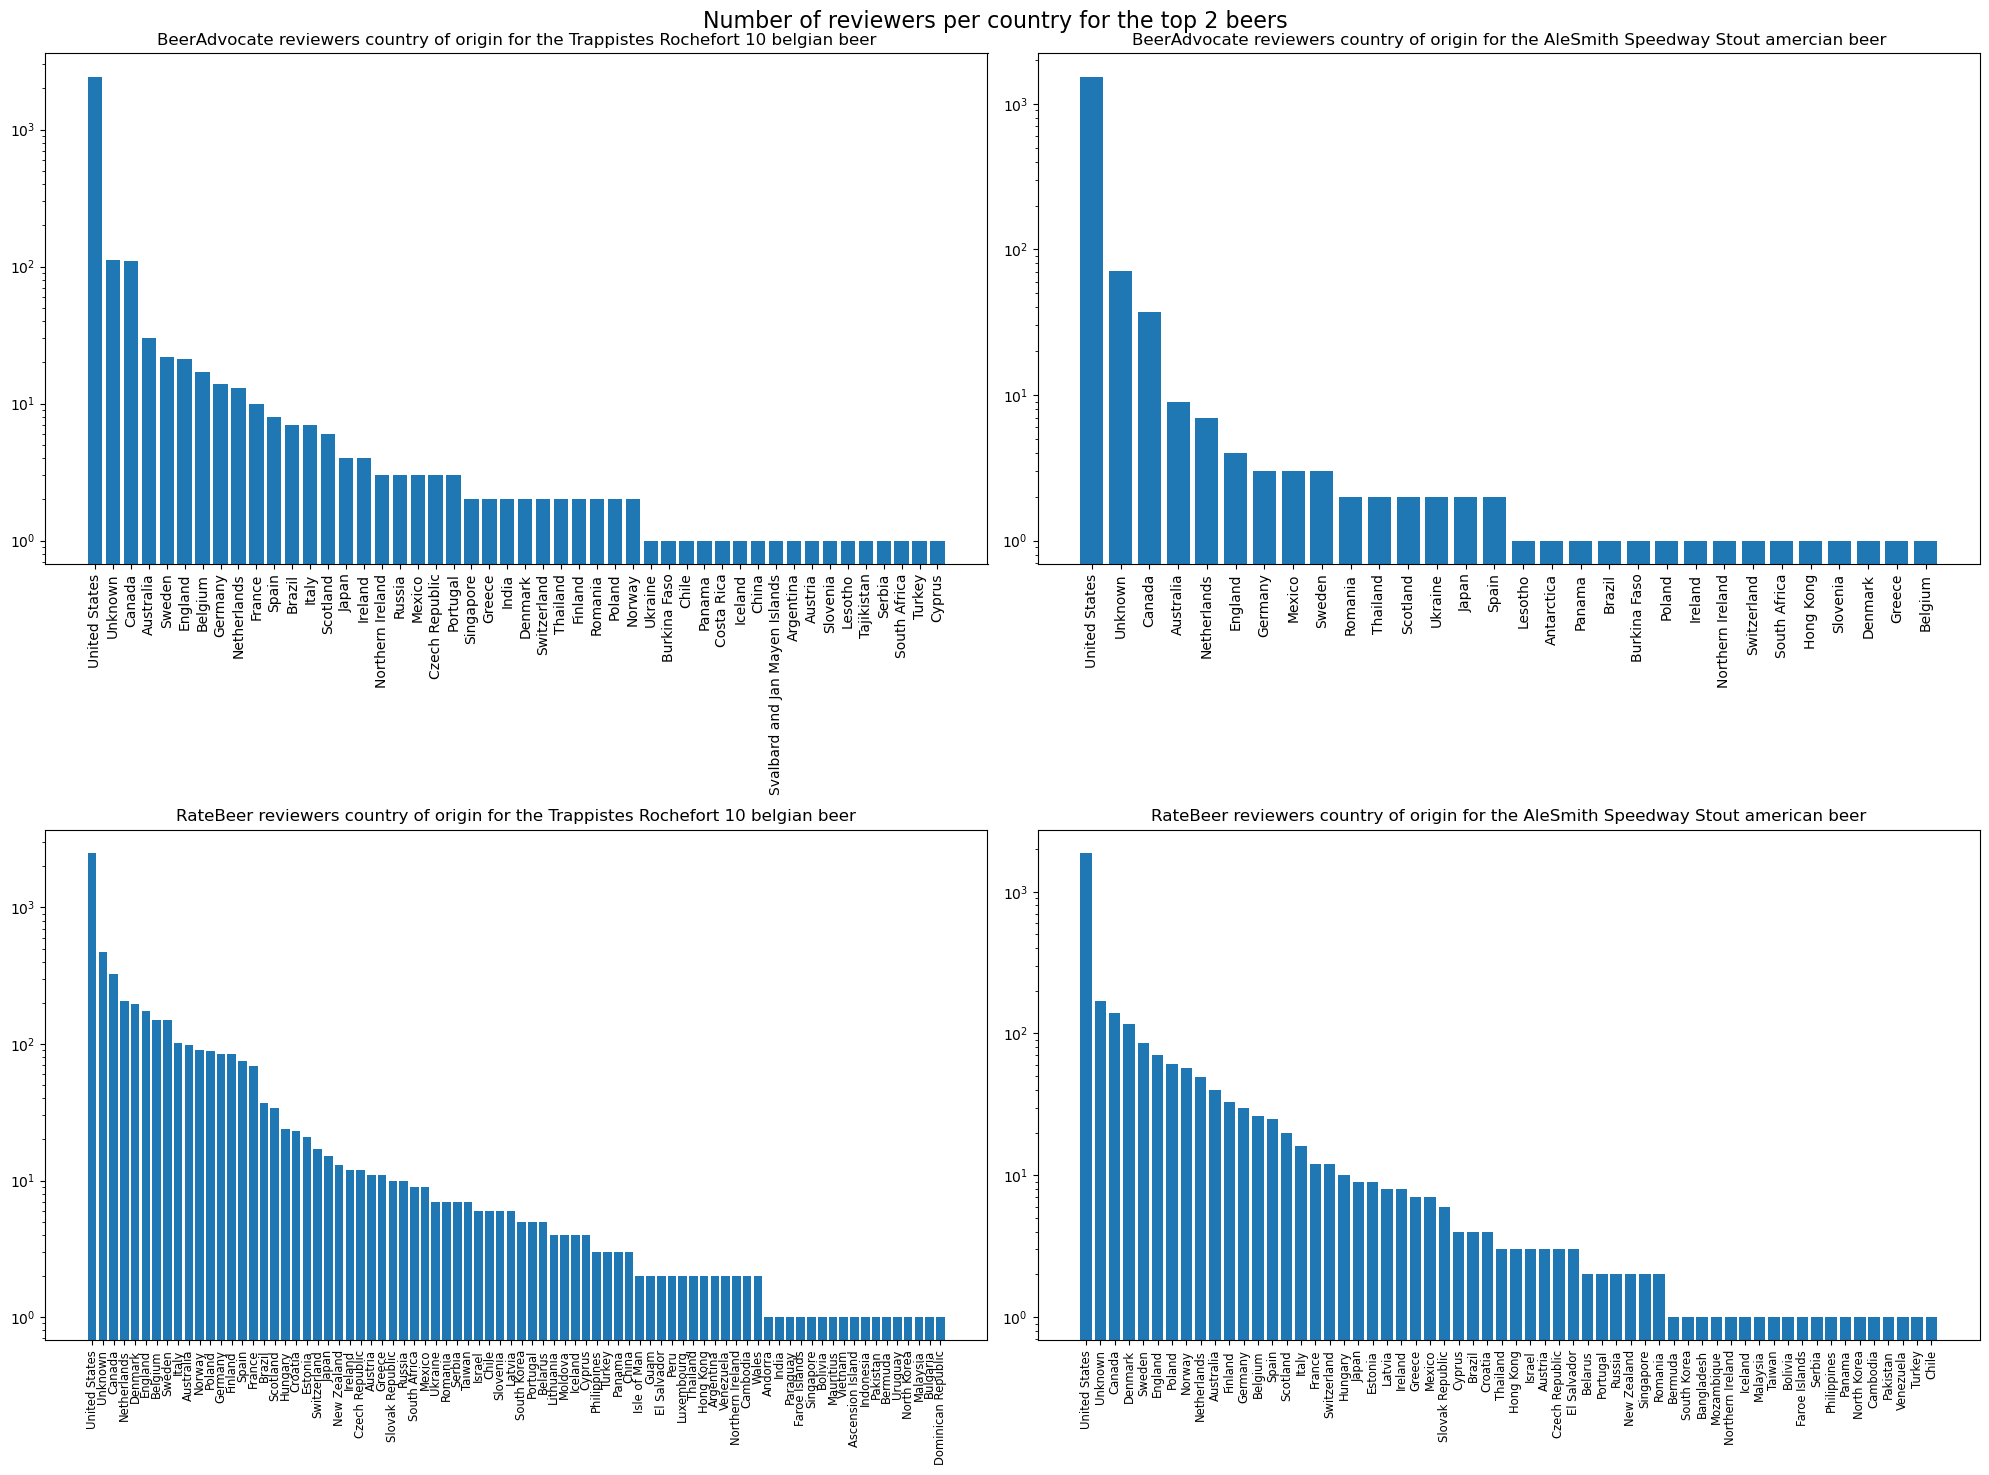

In [69]:
fig, axes = plt.subplots(2,2, figsize=(20,15))

axes[0,0].bar(x = value_counts_645['index'], height= value_counts_645['user_merged_location'])
axes[0,0].set_yscale('log')
axes[0,0].tick_params(axis='x', labelrotation = 90)
axes[0,0].set_title('BeerAdvocate reviewers country of origin for the Trappistes Rochefort 10 belgian beer')

axes[0,1].bar(x = value_counts_3833['index'], height= value_counts_3833['user_merged_location'])
axes[0,1].set_yscale('log')
axes[0,1].tick_params(axis='x', labelrotation = 90)
axes[0,1].set_title('BeerAdvocate reviewers country of origin for the AleSmith Speedway Stout amercian beer')

axes[1,0].bar(x = value_counts_2360['index'], height= value_counts_2360['user_merged_location'])
axes[1,0].set_yscale('log')
axes[1,0].tick_params(axis='x', labelrotation = 90,labelsize='small')
axes[1,0].set_title('RateBeer reviewers country of origin for the Trappistes Rochefort 10 belgian beer')

axes[1,1].bar(x = value_counts_14232['index'], height= value_counts_14232['user_merged_location'])
axes[1,1].set_yscale('log')
axes[1,1].tick_params(axis='x', labelrotation = 90,labelsize='small')
axes[1,1].set_title('RateBeer reviewers country of origin for the AleSmith Speedway Stout american beer')


fig.suptitle('Number of reviewers per country for the top 2 beers', fontsize=16)
fig.tight_layout()

Since most of the data lies in the United States, this is where most reviewers for these top 2 beers come from on both websites. This is followed by reviewers where there is no location information and Canada. Then follow mostly northern european countries. We can see belgium is usually among the countries that review the most (especially when it comes to their own beers), and for the BeerAdvocate reviews on the american beers they are most definitely not among the top reviewers. This could maybe indicate belgians review their beers more.

To get an idea of how frequent it is that people drink locally made beers we calculate the percentage of entries for which the brewery location and user location are the same (here we use the merged_location column where all the united states are merged)

In [70]:
print(f'{"Percentage of users on the BeerAdvocate website that drink local beers for the top 20 most liked beers across both websites (US merged):"} { round(np.count_nonzero(top_20_beers_BA["brewery_merged_location"] == top_20_beers_BA["user_merged_location"])/len(top_20_beers_BA)*100,2) }{"%"}')
print(f'{"Percentage of users on the RateBeer website that drink local beers for the top 20 most liked beers across both websites (US merged):"} { round(np.count_nonzero(top_20_beers_RB["brewery_merged_location"] == top_20_beers_RB["user_merged_location"])/len(top_20_beers_RB)*100,2) }{"%"}')

Percentage of users on the BeerAdvocate website that drink local beers for the top 20 most liked beers across both websites (US merged): 46.53%
Percentage of users on the RateBeer website that drink local beers for the top 20 most liked beers across both websites (US merged): 26.49%


Next we look at those percentages without merging the united states:

In [71]:
print(f'{"Percentage of users on the BeerAdvocate website that drink local beers for the top 20 most liked beers across both websites:"} { round(np.count_nonzero(top_20_beers_BA["brewery_location"] == top_20_beers_BA["user_location"])/len(top_20_beers_BA)*100,2) }{"%"}')
print(f'{"Percentage of users on the RateBeer website that drink local beers for the top 20 most liked beers across both websites:"} { round(np.count_nonzero(top_20_beers_RB["brewery_location"] == top_20_beers_RB["user_location"])/len(top_20_beers_RB)*100,2) }{"%"}')

Percentage of users on the BeerAdvocate website that drink local beers for the top 20 most liked beers across both websites: 5.55%
Percentage of users on the RateBeer website that drink local beers for the top 20 most liked beers across both websites: 4.6%


Since these percentages are much lower, it will be interesting to analyze this for each state of the US. Also it would be judicious to normalize this data since we could have large states which have a higher number of reviewers for the same beer.

Since we could obtain a dataframe comparing locations of users and breweries, this idea is quite feasible and we can explore other ideas and visualizations with this information.
For the continuation of this part in milestone P3, we can perhaps explore other ideas such as : <br>
- Explore which US rate which US states beers: we would like to create an interactive map where when you hover over a state and get information about the beers, users and breweries of that particular state

# Idea 3 : political and cultural events effect on beer reviews:

## Do reviews of chinese beers of US users correlate with how US citizens view China ?:

We were interested to see how the political climate influences the ratings that users give for certain beers. We were thinking of the trade war between China and the united states and how these tensions would affect the ratings of US users on Chinese beers. <br>
We realized that our data spans from 1996 to 2017. The (open) trading war started only with the presidency of Donald Trump, who was elected in 2016. <br>
Therefore, the trading war is not a good phenomenon to investigate on (due to missing data).

In [75]:
print(df_reviews_all.date.min())
print(df_reviews_all.date.max())

1996-08-22 10:00:00
2017-08-01 10:00:00


However, we found a paper talking about the public opinion in the US towards China and how this public opinion evolved over time. <br>
The period of 1996 to 2017 was covered as well. <br>
It is a book called "Winning American Hearts and Minds" by Xiuli Wang. <br>
We will not enter into too many details of the document, as it will turn out that other factors will make the work on China-US relationsship impossible. <br>

The first thing that we had to check, was whether there are chinese beers (beers from chinese breweries) in the dataset:

In [76]:
print(len(RB_breweries[RB_breweries['location']=='China']))
print(len(BA_breweries[BA_breweries['location']=='China']))

188
66


Indeed there are at least 188 breweries. <br>
We did not sum up the breweries of the two datasets, because a lot of the breweries are in both datasets and dropping duplicates only works to a limited point as the names of the breweries are often written in different manners. <br>

In [77]:
chinese_breweries_RB = RB_breweries[RB_breweries['location']=='China']
chinese_breweries_BA = BA_breweries[BA_breweries['location']=='China']

As mentioned above, there is a certain redundancy of breweries in the two datasets. <br>
To check the feasability of our task we use a conservative approach and only look at the beers produced in the breweries mentioned in the RB dataset.

In [78]:
print('in total, all the chinese breweries in the dataset RB produce a number of ' + str(chinese_breweries_RB['nbr_beers'].sum()) + ' beers.')

in total, all the chinese breweries in the dataset RB produce a number of 1316 beers.


We find that there are 1316 chinese beers that can be rated in the RB dataset.

As mentioned above, the breweries have not exactly the same wording. <br>
Therefore we concatenate the two dataframes containing information about the breweries so that we can iterate over all possible wordings.

In [79]:
chinese_breweries = pd.concat([chinese_breweries_RB['name'], (chinese_breweries_BA['name'])], axis=0)

In a next step we investigate how many chinese beers were reviewed in both datasets:

In [80]:
print('In the BA dataframe we find ' + str((len(df_BA_reviews[df_BA_reviews['brewery_name'].isin([chinese_breweries])]))) + ' ratings for chinese beer')
print('In the RB dataframe we find ' + str((len(df_RB_reviews[df_RB_reviews['brewery_name'].isin([chinese_breweries])]))) + ' ratings for chinese beer')

In the BA dataframe we find 0 ratings for chinese beer
In the RB dataframe we find 0 ratings for chinese beer


There are no ratings about chinese beers neither in BA nor in RB.

This complete lack of data forces us to switch tracks and abandon the idea of investigating the influence of the public opinion of US citizens on the ratings US users give for chinese beers.

## Influence of Brexit on reviews of US users on british beer:

Unfortunately, it is impossible to investigate the influence of politics on ratings of beers in the context of china-US relation. <br>
We want to find out how politics influence our relationship to beer. <br>

So we searched for another possibility were we should have more data. <br>
In June 2016 Great Britain decided in the famous BREXIT referendum that they want to leave the EU. <br>
This has made big waves in global politics and influenced the relationship of GB with other countries in various manners. <br>
It weakened the european collaboration and on the same hand affected the GB-US relationsships, as the Britains were looking for new partners. <br>
We are interested in the influence of this change in political climate on the beer reviews. <br>
Namely, how the ratings of british beer by US users changed after the acceptance of the referendum.

First we approve that we have data from before and after June 2016, to make sure that we can compare the situation before with the situation after the referendum.

In [38]:
print(df_reviews_all.date.min())
print(df_reviews_all.date.max())

1996-08-22 10:00:00
2017-08-01 10:00:00


### Get Reviews about british beer:

The code to extract british beer takes some time to compute. <br>
Therefore, we run it just once and save the dataframe as a csv file. <br>
This allows faster access after restarting the runtime or closing the program.

The commented code is the one that generated the dataframe only containing reviews on british beer and saved the dataframes in form of csv files.

In [32]:
'''
df_british_beers_RB = df_RB_reviews[(df_RB_reviews['brewery_location']=='Northern Ireland') |
                                (df_RB_reviews['brewery_location']=='Wales')  |
                                (df_RB_reviews['brewery_location']=='Scotland') |
                                (df_RB_reviews['brewery_location']=='England')]

df_british_beers_BA = df_BA_reviews[(df_BA_reviews['brewery_location']=='Northern Ireland') |
                                (df_BA_reviews['brewery_location']=='Wales')  |
                                (df_BA_reviews['brewery_location']=='Scotland') |
                                (df_BA_reviews['brewery_location']=='England')]


df_british_beers_RB.to_csv(PATH+'/DataframeStorage/df_british_beers_RB.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)
df_british_beers_BA.to_csv(PATH+'/DataframeStorage/df_british_beers_BA.csv', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'brewery_location', 'brewery_merged_location', 'user_location', 'user_merged_location'], index=False)
'''

The stored csv are opened as dataframes and the date (saved as string) is translated into datetime.

In [17]:
df_british_beers_RB = pd.read_csv(PATH+'/DataframeStorage/df_british_beers_RB.csv')
df_british_beers_BA = pd.read_csv(PATH+'/DataframeStorage/df_british_beers_BA.csv')

#Transform the column with the dates from string to datetime
df_british_beers_RB['date'] = pd.to_datetime(df_british_beers_RB['date'], format="%Y-%m-%d %H:%M:%S")
df_british_beers_BA['date'] = pd.to_datetime(df_british_beers_BA['date'], format="%Y-%m-%d %H:%M:%S")

For easier handling and better lisibility of the code, all the ratings for british beer are concatenated into one dataframe

In [18]:
df_british_beers_all = pd.concat([df_british_beers_BA, df_british_beers_RB], axis=0)

We want to see in a first step how many reviews we can work with.

In [19]:
#count the number of reviews we can work with.
print('in RB we have: ' + str(len(df_british_beers_RB)) + ' reviews about british beer.')
print('in BA we have: ' + str(len(df_british_beers_BA)) + ' reviews about british beer.')
print('Which makes a total of: ' + str(len(df_british_beers_all)) + ' reviews about british beer.')

in RB we have: 774523 reviews about british beer.
in BA we have: 95800 reviews about british beer.
Which makes a total of: 870323 reviews about british beer.


We have a total amount of 870'323 reviews on british beer, which is a dataset size with which we can work.

We are only interested in reviews from US users. <br>

In [20]:
df_british_beers_US_users = df_british_beers_all[df_british_beers_all['user_merged_location'] == 'United States']

In [21]:
print('Out of the ' + str(len(df_british_beers_all)) + ' reviews, ' + str(len(df_british_beers_US_users)) + ' are from users from the US')

Out of the 870323 reviews, 168885 are from users from the US


We can see that unfortunately only a fraction of the reviews about the british beer is from users from the US.

To get a better idea of the distribution of the users countries of origin for the reviews on british beer we plot a bar plot. <br>

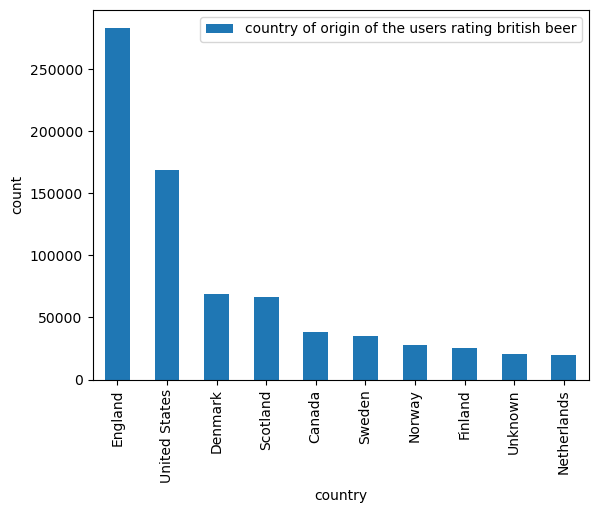

In [22]:
counts_reviews_british_beer = df_british_beers_all.groupby('user_merged_location').count().reset_index()
counts_reviews_british_beer = counts_reviews_british_beer.sort_values('user_name', ascending=False)


axes = counts_reviews_british_beer[:10].plot.bar(x = 'user_merged_location', y='beer_name')
axes.set_ylabel('count')
axes.set_xlabel('country')
axes.legend(['country of origin of the users rating british beer'])


The figure above shows that a big part of the reviews about british beer are from british users (England, Scotland). <br>
After the USA there are also many users from other european countries or canada. 

Next, we want to compare how many of the reviews were given before and after the Brexit.

In [39]:
brexit_date = datetime.datetime(2016, 6, 23, 0, 0, 0)

print('From the '+ str(len(df_british_beers_US_users)) +' US ratings of british beer,')
print(str(len(df_british_beers_US_users[df_british_beers_US_users['date'] < brexit_date])) +' were given before Brexit and only ')
print(str(len(df_british_beers_US_users[df_british_beers_US_users['date'] > brexit_date])) +' are submitted after the referendum. ')

From the 168885 US ratings of british beer,
164026 were given before Brexit and only 
4859 are submitted after the referendum. 


We only have 4859 US ratings of british beers after the Brexit. <br>
We will try to work with that, but there is the possibility that the data size will not be sufficient. <br>
Especially if we want to investigate the effect in different federal states.

We want to get an idea of the distribution of reviews in different federal states:

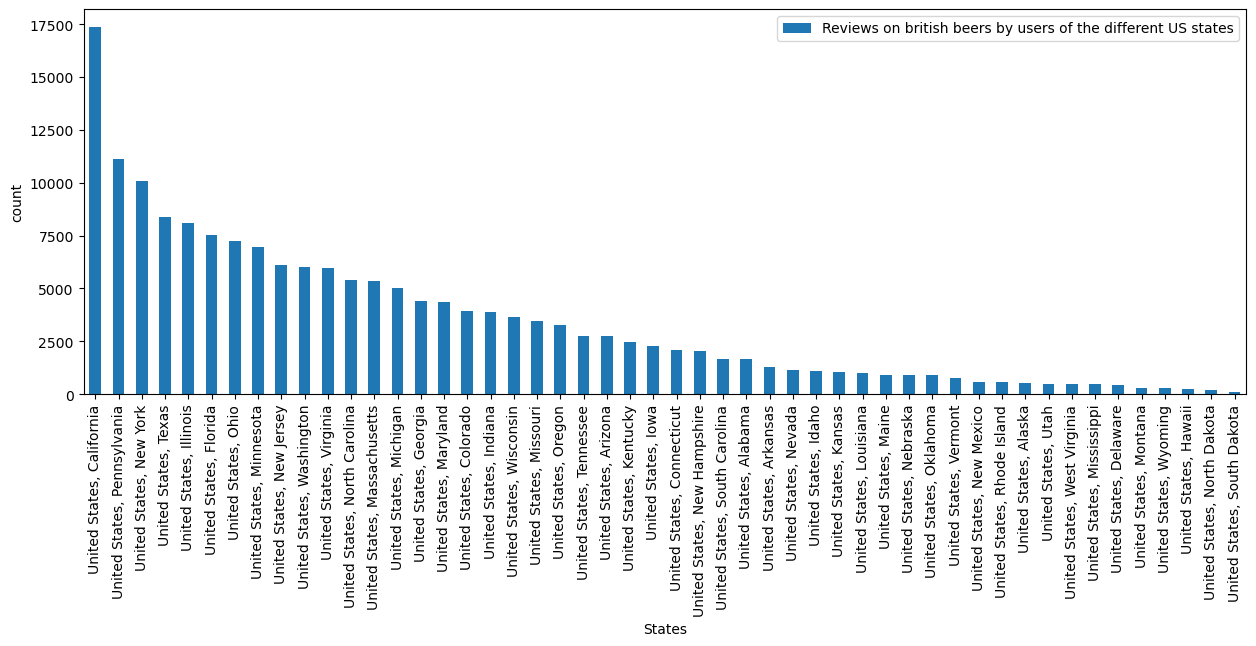

In [24]:
counts_US_reviews_british_beer = df_british_beers_US_users.groupby('user_location').count().reset_index()
counts_US_reviews_british_beer = counts_US_reviews_british_beer.sort_values('user_name', ascending=False)

axes = counts_US_reviews_british_beer.plot.bar(x = 'user_location', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('States')
axes.legend(['Reviews on british beers by users of the different US states'])

In [25]:
counts_US_reviews_british_beer['beer_name'].describe()

count       50.00000
mean      3377.70000
std       3495.79878
min         82.00000
25%        796.00000
50%       2158.00000
75%       5285.50000
max      17346.00000
Name: beer_name, dtype: float64

We can see that there are many ratings on british beer in California and fewer ratings in other states. <br>
The lowest number of ratings we find in South Dakota with 82. <br>
One fourth of the states have 796 or less ratings, which can be tough to work with.

To get an idea of the influence of the Brexit on the reviews we need ratings before and after the Brexit. <br>
As 99% of the reviews in question were done before June 2016 we are less concerned about the number of ratings before Brexit. <br>
After Brexit, however, we have a much smaller sample size. <br>
To get a head of the numbers of reviews after the Brexit, we use a bar plot for to visualize the ratings per federal state.

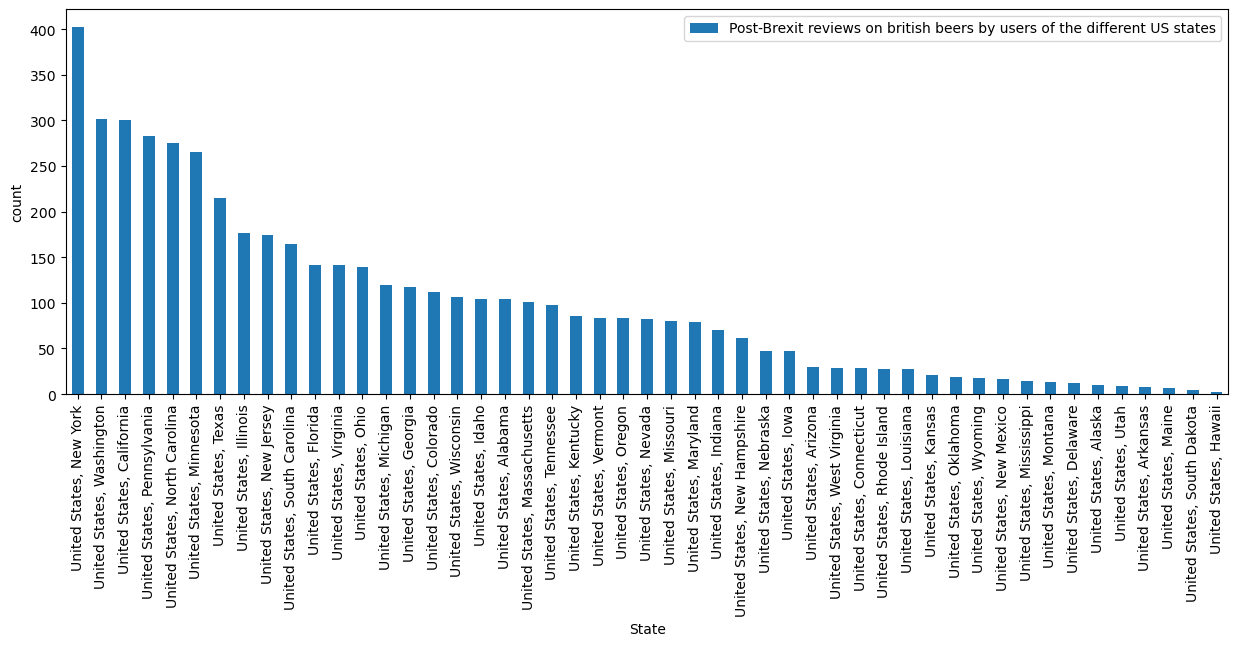

In [26]:
counts_US_reviews_british_beer_postBrexit = df_british_beers_US_users[df_british_beers_US_users['date'] > brexit_date].groupby('user_location').count().reset_index()
counts_US_reviews_british_beer_postBrexit = counts_US_reviews_british_beer_postBrexit.sort_values('user_name', ascending=False)

axes = counts_US_reviews_british_beer_postBrexit.plot.bar(x = 'user_location', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('State')
axes.legend(['Post-Brexit reviews on british beers by users of the different US states'])

In [27]:
counts_US_reviews_british_beer_postBrexit['beer_name'].describe()

count     49.000000
mean      99.163265
std       95.219559
min        2.000000
25%       21.000000
50%       82.000000
75%      139.000000
max      402.000000
Name: beer_name, dtype: float64

When plotting the data about the reviews we got about british beer of US users after the Brexit referendum, <br>
the first thing that catches the eye is that one states doesn't even show up (count = 49). <br>
Meaning that for one federal state we have no review about british beer after brexit at all. <br>
This can possibly be an effect as well. If there were ratings at some frequency before Brexit, and after Brexit these ratings disappear,
this would also count as effect. <br>
Nevertheless, we will try to avoid making analysis with states that have very small sample size. <br>
To prevent white spots on our map as much as possible, we consider grouping states with similar political climates and small sample sizes. <br>
This could provide in some cases workable samples. <br> 
Moreover, the state with the highest amount of reviews (Washington) has a mere amount of 402 ratings. <br>
It will be hard to get significant effects with a mean of 100 ratings. <br>

To avoid a simpson paradoxon we should avoid differences in the sample sizes of pre and post Brexit groups. <br>
Should one proceed this analysis, we would suggest to take the amount of reviews that are present after the brexit (let's say we have X reviews), <br>
And compare them to the X most recent reviews before Brexit.

In the case of too low sample sizes we still would have the options of grouping all democratic states and all republican states together. <br>
This would rise questions for the swing states, where we would either look at the latest elections or make a third group for the swing states themselves.

To find other possible countries for which we would have sufficient US reviews to investigate influence of international relations on beer rating behavior of US users, we plot what kind of beer (what origin) US users rate. <br>
This could provide more promising countries than China or GB in context of Brexit.

In [28]:
df_US_reviews = df_reviews_all[df_reviews_all['user_merged_location'] == 'United States']

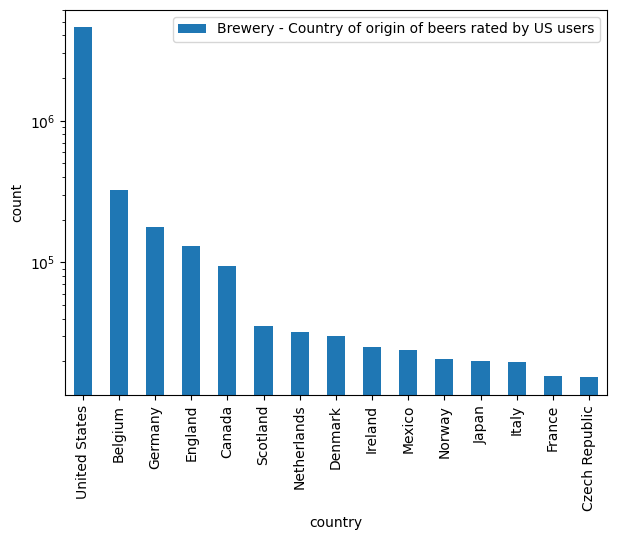

In [29]:
rating_nationality_counts = df_US_reviews.groupby('brewery_merged_location').count().reset_index()
rating_nationality_counts = rating_nationality_counts.sort_values('user_name', ascending=False)


axes = rating_nationality_counts[:15].plot.bar(x = 'brewery_merged_location', y='beer_name', logy=True, figsize=(7,5))
axes.set_ylabel('count')
axes.set_xlabel('country')
axes.legend(['Brewery - Country of origin of beers rated by US users'])

Note that the y-axis is logarithmic. <br>
We see that the big majority of reviews of US users are done on US beers. <br>
So, to find effects of politics on beer reviews, international relations are not the most ideal approach given the distribution of the data. <br>

We decide to better investigate US beers in context of US politics. <br>
An interesting political phenomenon are scandals. <br>
In the next paragraph we will focus on scandals of the Anheuser-Busch brewery (which is a US brewery) and investigate whether there is sufficient data to conduct an analyis of its influence on US reviews on beers of Anheuser-Busch.

## Budweiser Anheuser-Busch case

In 2013 Anheuser-Busch was accused of watering down their beer called Budweiser. The suit was filed by Pennsylvania, California and other States. The suits were later thrown out. <br>
However, the scandal was in the media, and we assume that people who rate beer also are informed about news situation concerning beer. <br>
Interestingly for us, Anheuser-Busch did other scandals that we can also investigate if the data is sufficient.

In [30]:
#Maybe we can move that to the top of the notebook
all_breweries = pd.concat([BA_breweries, RB_breweries], axis = 0)
US_breweries = all_breweries[all_breweries['merged_location'] == 'United States']

In [37]:
US_breweries[US_breweries['name'].str.startswith('Anheuser-Busch')].head()

,location,name,nbr_beers,merged_location
id,,,,
36293,"United States, Colorado",Anheuser-Busch,185,United States
29,"United States, Missouri",Anheuser-Busch,185,United States
84,"United States, Missouri",Anheuser-Busch InBev,216,United States


In [49]:
df_Budweiser_reviews = df_US_reviews[df_US_reviews['brewery_name'].str.startswith('Anheuser')]
#as there is a Anheuser-Busch brewery in India we filter all non-US Anheuser-Busch breweries out
df_US_Budweiser_reviews = df_Budweiser_reviews[df_Budweiser_reviews['brewery_merged_location'] == 'United States']

In [50]:
print('We have ' + str(len(df_US_Budweiser_reviews[df_US_Budweiser_reviews['brewery_merged_location'] == 'United States'])) + ' reviews \
for Anheuser-Busch beers from US users.')

We have 73971 reviews for Anheuser-Busch beers from US users.


We have 73'971 reviews of US users about beers from the Anheuser-Busch brewery.

As we would like to compare different states, we will also plot the state distribution of the reviews:

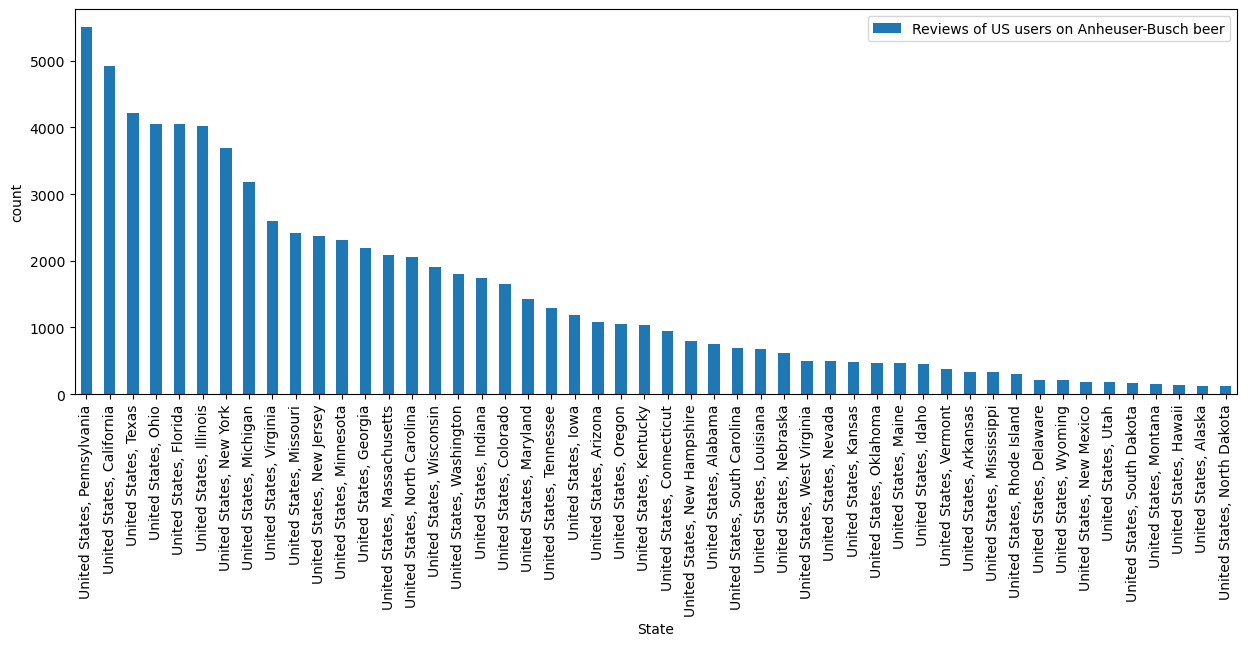

In [29]:
counts_US_Budweiser_reviews = df_US_Budweiser_reviews.groupby('user_location').count().reset_index()
counts_US_Budweiser_reviews = counts_US_Budweiser_reviews.sort_values('user_name', ascending=False)

axes = counts_US_Budweiser_reviews.plot.bar(x = 'user_location', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('State')
axes.legend(['Reviews of US users on Anheuser-Busch beer'])

In [31]:
counts_US_Budweiser_reviews['beer_name'].describe()

count      50.000000
mean     1479.420000
std      1421.612954
min       115.000000
25%       390.000000
50%       985.500000
75%      2170.750000
max      5501.000000
Name: beer_name, dtype: float64

We have some states with very low counts of reviews, but some with a considerable number of reviews. <br>
To maybe still allow a state dependent analysis, we can consider the possiblity of grouping "similar" states together to have bigger sample sizes.

## Investigate the influence of the financial crisis in 2008 on the appearance of price related words in the ratings.
#### Possibly compare the results in rich and poor states

The general idea is to look whether the price plays a more important role during economically difficult times (which we expect to do). <br>
The approach is to find the text reviews mentionning any price related words and see whether the frequency increased after the onset of the crisis.

First we define the words that we want the text reviews to scan for. <br>
We will add words in the process of Milestone P3.

As a sidenote: <br>
We will look at all the reviews in one dataframe for Milestone P2. <br>
We are aware that the two different rating platforms RB and BA could contain "unknown variables" that could influence our results, also due to their unequal sample size. <br>
We will look at possible such effects during milestone P3, here we will consider the all the reviews as coming from one sample.

In [32]:
price_related_words = ['price','cheap','expensive', 'inexpensive', 'cost', 'money', 'costly', 'pricey']

In the following cell we have the algorithm extracting the indices for the reviews where the words are mentionned. <br>
The algorithm is still quite clumsy. <br>
Therefore, we run it only once and save the list of indices as a pickle that we can open easily.

In [33]:
'''
index_price = []
k = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"


for index, row in df_US_reviews.iterrows():
    #extract the text
    text = str(row['text'])
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in price_related_words]) > 0):
        index_price.append(index)


with open("../DataframeStorage/index_price.bin", "wb") as output:
    pickle.dump(index_price, output)
'''

Open the pickle as a list:

In [31]:
with open("../DataframeStorage/index_price.bin", "rb") as data:
    index_price = pickle.load(data)

In [32]:
df_prices = df_US_reviews.loc[index_price]

First we will see how many reviews mention a price:

In [53]:
print(str(len(index_price)) + ' of the reviews mention prices')

189545 of the reviews mention prices


We have almost 190'000 american reviews mentionning price related words. <br>
This is a good sample size to start with.

However, as we want to compare different states, we should use visualization to see how many ratings we have per state:

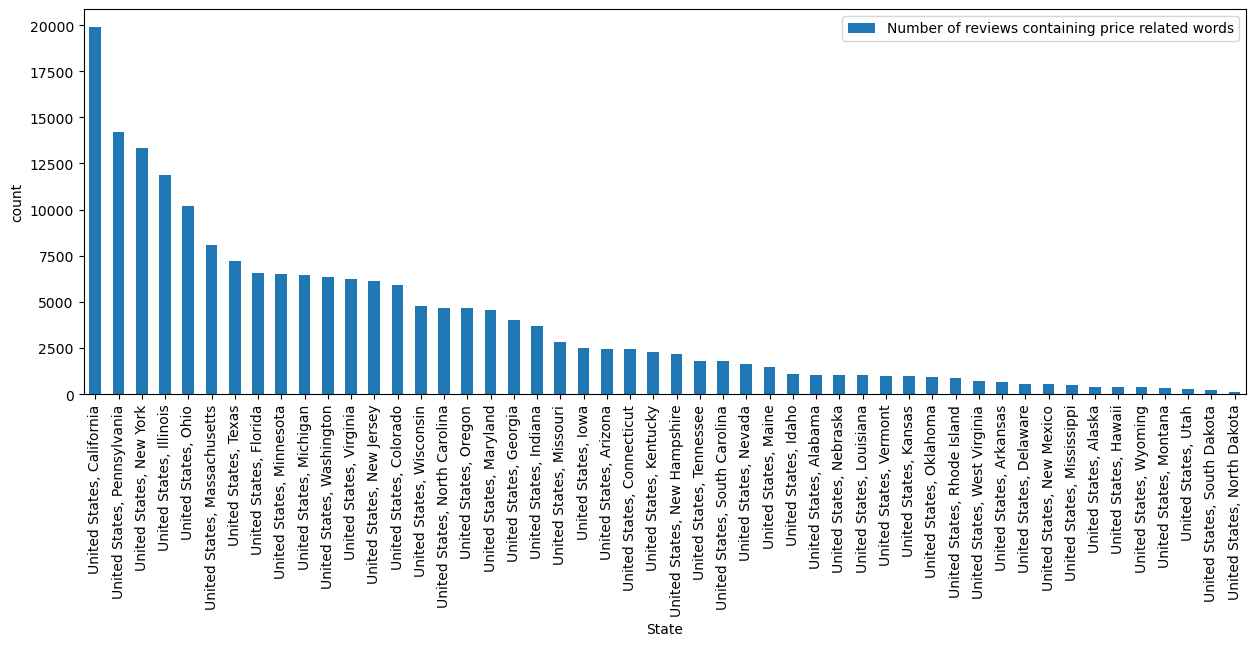

In [54]:
counts_price_reviews = df_prices.groupby('user_location').count().reset_index()
counts_price_reviews = counts_price_reviews.sort_values('user_name', ascending=False)

axes = counts_price_reviews.plot.bar(x = 'user_location', y='beer_name', figsize=(15,5))
axes.set_ylabel('count')
axes.set_xlabel('State')
axes.legend(['Number of reviews containing price related words'])

In [55]:
counts_price_reviews['beer_name'].describe()

count       50.000000
mean      3790.900000
std       4215.818492
min        132.000000
25%        863.750000
50%       2245.500000
75%       6066.500000
max      19875.000000
Name: beer_name, dtype: float64

We have a lot of states with a very high number of reviews mentioning price related words. <br>
However, there is one fourth of the states who has 860 reviews or less. <br>
If we want to compare different years we need to expect small sample sizes for the states with less ratings. <br>
As mentioned above we can consider here as well to group states.

To see if there is a change during crisis we will compare the relative frequency of price related words for different time intervals (i.e. for different years). <br>
It is interesting to see how many yearly reviews mentioning price there are:

To do so we first create a new column containing the year in which the review was done. <br>
This will allow the grouping by year.

In [59]:
df_US_reviews['date'] = pd.to_datetime(df_US_reviews['date'], format="%Y-%m-%d %H:%M:%S")

C:\Users\flori\AppData\Local\Temp\ipykernel_14480\308337463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US_reviews['date'] = pd.to_datetime(df_US_reviews['date'], format="%Y-%m-%d %H:%M:%S")


In [60]:
df_prices['year'] = df_prices['date'].dt.year
df_US_reviews['year'] = df_US_reviews['date'].dt.year

C:\Users\flori\AppData\Local\Temp\ipykernel_14480\2052218592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US_reviews['year'] = df_US_reviews['date'].dt.year


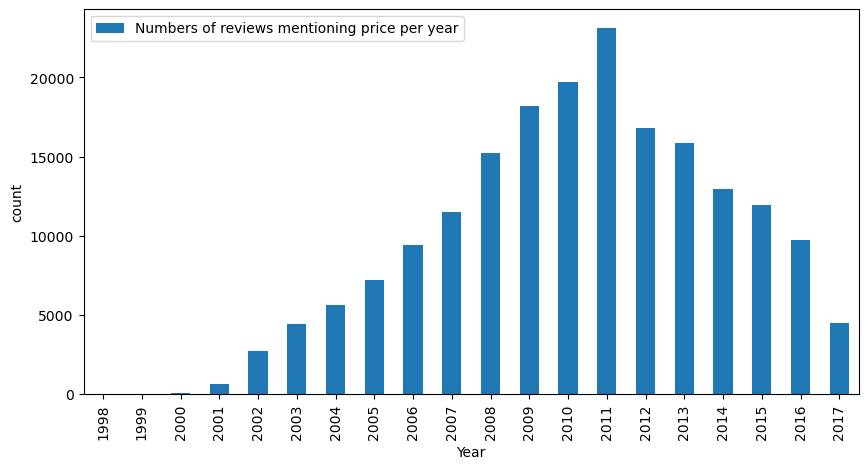

In [ ]:
counts_price_reviews = df_prices.groupby('year').count().reset_index()


axes = counts_price_reviews.plot.bar(x = 'year', y='beer_name', figsize=(10,5))
axes.set_ylabel('count')
axes.set_xlabel('Year')
axes.legend(['Numbers of reviews mentioning price per year'])

This is an interesting curve but actually we need to put that into relationship with the total reviews per year.

First we plot the total number of yearly reviews in the USA.

In [ ]:
counts_yearly_US_reviews = df_US_reviews.groupby('year').count().reset_index()

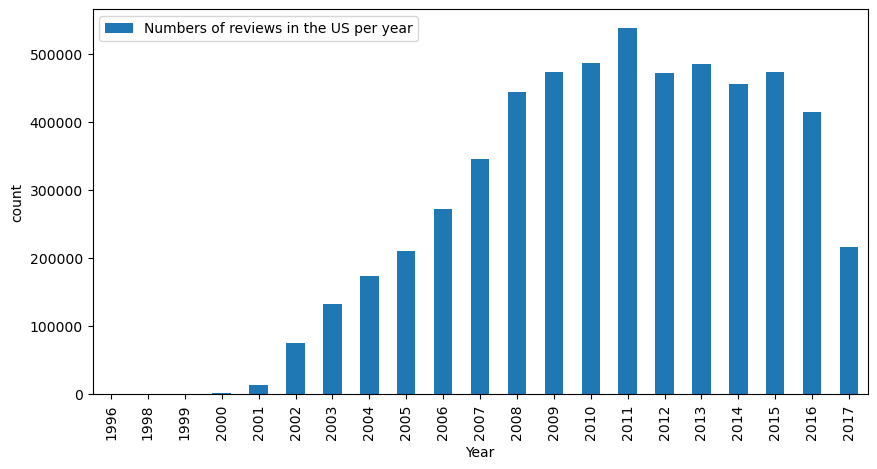

In [128]:

axes = counts_yearly_US_reviews.plot.bar(x = 'year', y='beer_name', figsize=(10,5))
axes.set_ylabel('count')
axes.set_xlabel('Year')
axes.legend(['Numbers of reviews in the US per year'])

Now that we know the total number of american reviews we want to plot the ratio of price related words mentioned per year to the total amount of reviews in the same year. <br>
This will allow to get an insight on the frequency at which these words appear.

Note: <br>
As there is only one review in 1996 and no review in 1997 we drop these years.
We only need to drop the first entry of the list with all US reviews, as the one existing review does not mention price related words. <br>

as 1997 had no reviews there is no entry for the year 1997

In [61]:
print('There are ' + str(len(df_US_reviews[df_US_reviews['year'] == 1996])) + ' reviews from the year 1996')
print('There are ' + str(len(df_US_reviews[df_US_reviews['year'] == 1997])) + ' reviews from the year 1997')
print('There are ' + str(len(df_US_reviews[df_US_reviews['year'] == 1998])) + ' reviews from the year 1998')



There are 1 reviews from the year 1996
There are 0 reviews from the year 1997
There are 159 reviews from the year 1998


To get the ratio we divide the price-mentioning reviews by the total reviews. <br>
For simplicity we transform the Series into lists.

In [156]:
list_price_reviews = counts_price_reviews['beer_name'].tolist()
list_US_reviews = counts_yearly_US_reviews['beer_name'].tolist()
list_US_reviews.pop(0)

1

we use the operator "truediv" to divide entry by entry of one list by another list. <br>
To plot the ratios we define the X axis (years 1998 to 2017)

In [161]:
from operator import truediv
ratio = list(map(truediv, list_price_reviews, list_US_reviews))
ratio = [elemt*100 for elemt in ratio]

X = list(range(1998,2018))

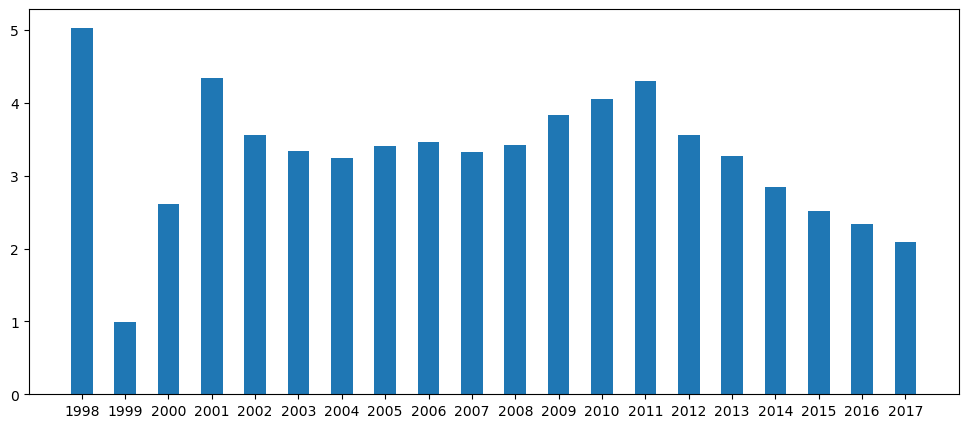

In [162]:
plt.figure(figsize=(12,5))
plt.bar(X,ratio, width = 0.5)
plt.xticks(X)
plt.show()

The numbers we obtained can be interpreted in the Milestone P3

In a next step we can also take a look at RB and BA. <br>
The two subsets could contain "unknown variables". <br>
For example that users in RB are more concerned about prices than users in BA. <br>
If there are changes in the fraction between RB and BA reviews over the years, this could influence the obtained result.


# Genetic modified crops in beer production and how it affects the ratings:

Gentechnology is a very emotional topic. <br>
We stumbled over a few US articles discussing emotional discourse concerning beers produced with genetically modified crops. <br>
As the topic polarizes we want to see if and how it affects the reviews. <br>
We follow the approach of finding reviews mentionning gentech (the users are aware of gentech in the beer) <br>
and to then investigate whether these reviews give better or worse scores than the average. <br>
We can either compare it to the global score of the beer or to the average score that the user gave to beers.

First we define the words that we scan the text reviews for. <br>
We will add words during the milestone P3.

In [36]:
gene_related_words = ['gentech','gene', 'gen', 'genetic','genetically', 'GMO']

In the following cell we have the algorithm extracting the indices for the reviews where the words are mentionned. <br>
The algorithm is still quite clumsy. <br>
Therefore, we run it only once and save the list of indices as a pickle that we can open easily.

In [37]:
'''
index_gene = []
k = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"


for index, row in df_US_reviews.iterrows():
    #extract the text
    text = str(row['text'])
    #split the text into words
    words = text.split(' ')
    #remove all characters that arent letters
    for i, word in enumerate(words):
        words[i] = "".join(list(filter(lambda x: x in k, word)))
    #Check whether a word related to "can" is in the text
    if (len([x for x in words if x in gene_related_words]) > 0):
        index_gene.append(index)

with open("../DataframeStorage/index_gene.bin", "wb") as output:
    pickle.dump(index_gene, output)

'''

Open the list via pickle read:

In [ ]:
with open("../DataframeStorage/index_gene.bin", "rb") as data:
    index_gene = pickle.load(data)

Count the number of reviews mentionning gentech:

In [165]:
print('we have ' + str(len(index_gene)) + ' reviews mentionning gentechnic or genetics.')

we have 225 reviews mentionning gentechnic or genetics.


225 reviews are not a lot. <br>
Still, we can see whether the ratings give lower or higher ratings than the average rating the beer obtained by other users. <br>
If the effect size is large, we can still get significant results. <br>

As europeans (were gentech is seen very critically) we expect to see lower ratings for reviews were genetic engineering is mentionned. <br>
We will explore this in the milestone P3 of the project.